In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
from root_numpy import root2array, rec2array


branch_names = """lepton pT, lepton eta, lepton phi,
missing energy magnitude, missing energy phi,
jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag,
jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag,
jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag,
jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag,
m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb,
m_wwbb""".split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)

signal = root2array("HIGGSsignal.root",
                    "tree",
                    branch_names)
signal = rec2array(signal)

backgr = root2array("HIGGSbackground.root",
                    "tree",
                    branch_names)
backgr = rec2array(backgr)

# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples
X = np.concatenate((signal, backgr))
y = np.concatenate((np.ones(signal.shape[0]),
                    np.zeros(backgr.shape[0])))

Welcome to JupyROOT 6.11/02


In [5]:
# import pandas.core.common as com
# from pandas.core.index import Index

# from pandas.tools import plotting
# from pandas.tools.plotting import scatter_matrix


# # Create a pandas DataFrame for our data
# # this provides many convenience functions
# # for exploring your dataset
# # need to reshape y so it is a 2D array with one column
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),
                  columns=branch_names+['y'])

            
# def signal_background(data1, data2, column=None, grid=True,
#                       xlabelsize=None, xrot=None, ylabelsize=None,
#                       yrot=None, ax=None, sharex=False,
#                       sharey=False, figsize=None,
#                       layout=None, bins=10, **kwds):
#     """Draw histogram of the DataFrame's series comparing the distribution
#     in `data1` to `data2`.
    
#     data1: DataFrame
#     data2: DataFrame
#     column: string or sequence
#         If passed, will be used to limit data to a subset of columns
#     grid : boolean, default True
#         Whether to show axis grid lines
#     xlabelsize : int, default None
#         If specified changes the x-axis label size
#     xrot : float, default None
#         rotation of x axis labels
#     ylabelsize : int, default None
#         If specified changes the y-axis label size
#     yrot : float, default None
#         rotation of y axis labels
#     ax : matplotlib axes object, default None
#     sharex : bool, if True, the X axis will be shared amongst all subplots.
#     sharey : bool, if True, the Y axis will be shared amongst all subplots.
#     figsize : tuple
#         The size of the figure to create in inches by default
#     layout: (optional) a tuple (rows, columns) for the layout of the histograms
#     bins: integer, default 10
#         Number of histogram bins to be used
#     kwds : other plotting keyword arguments
#         To be passed to hist function
#     """
        
#     if 'alpha' not in kwds:
#         kwds['alpha'] = 0.5

#     if column is not None:
#         if not isinstance(column, (list, np.ndarray, Index)):
#             column = [column]
#         data1 = data1[column]
#         data2 = data2[column]
        
#     data1 = data1._get_numeric_data()
#     data2 = data2._get_numeric_data()
#     naxes = len(data1.columns)

# #     fig, axes = plotting._subplots(naxes=naxes, ax=ax, squeeze=False,
# #                                    sharex=sharex,
# #                                    sharey=sharey,
# #                                    figsize=figsize,
# #                                    layout=layout)
#     fig, axes = plt.subplots(naxes=naxes, ax=ax, squeeze=False,
#                                    sharex=sharex,
#                                    sharey=sharey,
#                                    figsize=figsize,
#                                    layout=layout)
#     _axes = plotting._flatten(axes)

#     for i, col in enumerate(com._try_sort(data1.columns)):
#         ax = _axes[i]
#         low = min(data1[col].min(), data2[col].min())
#         high = max(data1[col].max(), data2[col].max())
#         ax.hist(data1[col].dropna().values,
#                 bins=bins, range=(low,high), **kwds)
#         ax.hist(data2[col].dropna().values,
#                 bins=bins, range=(low,high), **kwds)
#         ax.set_title(col)
#         ax.grid(grid)

#     plotting._set_ticks_props(axes, xlabelsize=xlabelsize, xrot=xrot,
#                               ylabelsize=ylabelsize, yrot=yrot)
#     fig.subplots_adjust(wspace=0.3, hspace=0.7)

#     return axes

# # Plot signal and background distributions for some
# # variables
# # The first two arguments select what is "signal"
# # and what is "background". This means you can
# # use it for more general comparisons of two
# # subsets as well.
# signal_background(df[df.y<0.5], df[df.y>0.5],
#                   column=["lepton_pT",
#                           "lepton_eta",
#                           "lepton_phi",
#                           "missing_energy_magnitude",
#                           "jet_3_pt"],
#                   bins=20)

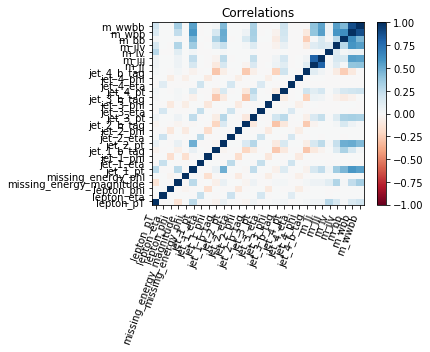

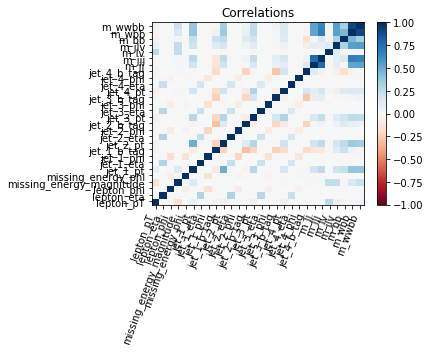

In [8]:
bg = df.y < 0.5
sig = df.y > 0.5

def correlations(data, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(df[bg].drop('y', 1))
correlations(df[sig].drop('y', 1))


In [9]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=492)

In [10]:
from keras import optimizers
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout

# Generate model
model = Sequential()
# Input layer
model.add(Dense(
    100, input_shape=(X_train.shape[1],), kernel_initializer='he_normal', activation='relu'))
# Hidden layers
for i in range(3):
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# Set loss and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(), metrics=['accuracy', ])

# Store model to file
# model.save('model.h5')
model.summary()
history = model.fit(X_train, y_train, epochs=2, batch_size=256,
                    validation_data=(X_eval,y_eval), verbose=1)


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
__________

2018-07-07 12:10:51.637463: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [11]:
from sklearn.metrics import accuracy_score, roc_curve, auc

train_predict = model.predict_proba(X_train)
test_predict = model.predict_proba(X_test)


fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, test_predict)
auc_dnn = auc(fpr_dnn, tpr_dnn)


FullThresholdSet = thresholds_dnn[np.argmin(abs(fpr_dnn-7e-5))]
print(1 - FullThresholdSet)

0.09385162591934204


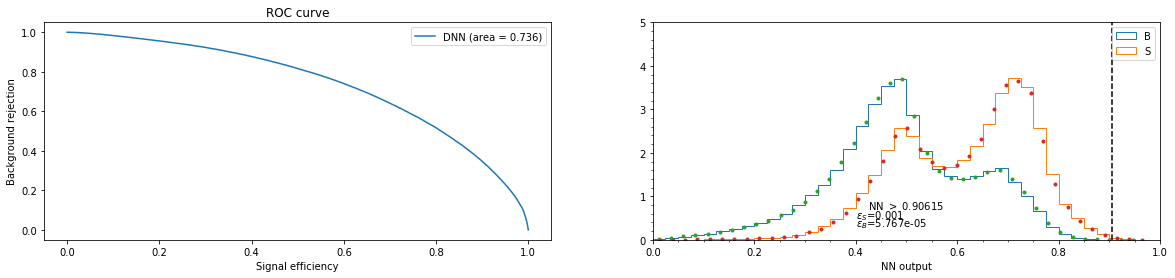

In [12]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(tpr_dnn, (1 - fpr_dnn), label='DNN (area = {:.3f})'.format(auc_dnn))
plt.legend(loc='lower right', frameon=False, fontsize=12)
plt.xlabel('Signal efficiency')
plt.ylabel('Background rejection')
plt.title('ROC curve')
plt.legend(loc='best')
# plt.xscale('log')
# plt.ylim(1e-6,1)

plt.subplot(1, 2, 2)
plt.hist(test_predict[y_test == 0], bins=40, range=(
    0, 1), density=True, histtype='step', label='B')
plt.hist(test_predict[y_test == 1], bins=40, range=(
    0, 1), density=True, histtype='step', label='S')
# plt.yscale('log')
plt.legend(loc='best')
plt.xlim(0, 1)
plt.ylim(1e-3, 5)
plt.vlines(FullThresholdSet, 1e-3, 1e3, linestyle='--')
plt.xlabel('NN output')

# print(test_predict.shape)
plt.text(0.5, 0.7, r"NN $>$ {0:.5f}".format(FullThresholdSet), ha='center')
plt.text(0.4, 0.50, r'$\epsilon_{S}$'+'={0:.3f}'.format(float(sum(
    test_predict[y_test == 1] > FullThresholdSet)[0])/sum(y_test == 1)), ha='left')
plt.text(0.4, 0.3, r'$\epsilon_{B}$'+'={0:.3e}'.format(float(sum(
    test_predict[y_test == 0] > FullThresholdSet)[0])/sum(y_test == 0)), ha='left')

countsS, bin_edgesS = np.histogram(
    train_predict[y_train == 0], 40, density=True)
bin_centresS = (bin_edgesS[:-1] + bin_edgesS[1:])/2.
# errS = np.sqrt(countsS)
plt.errorbar(bin_centresS, countsS, fmt='.')

countsB, bin_edgesB = np.histogram(
    train_predict[y_train == 1], 40, density=True)
bin_centresB = (bin_edgesB[:-1] + bin_edgesB[1:])/2.
# errB = np.sqrt(countsB)
plt.errorbar(bin_centresB, countsB, fmt='.')
plt.minorticks_on()
# plt.tight_layout()
plt.show()